# Dependencies

In [ ]:
pip install pymongo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install dnspython;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pymongo
from pymongo import MongoClient
import dns

In [ ]:
client = MongoClient("mongodb+srv://cluster0.fvum7vl.mongodb.net/class")
db = client.test

In [ ]:
pymongo.version

'4.3.3'

# Loading in data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# set up the MongoDB Atlas client
client = pymongo.MongoClient("mongodb+srv://cluster0.fvum7vl.mongodb.net/class",
                             username='jacquieguerra',
                             password='UsOybxH5Xlvc60ZC',
                             retryWrites=True,
                             w='majority')

# select the database and collection you want to query
db = client['class']
collection_x = db.housing
collection_y = db.housing_price

collection = db.housing_aggregated

# query the collection and convert the results to a pandas dataframe
query = {}
cursor = collection.find(query)
df = pd.DataFrame(list(cursor))
df.head()


,_id,size_sqft,num_bedrooms,num_floors,age_of_home,housing_id,price
0,643dda32a050f33d7fefeaa7,1836.0,3.0,1.0,17.0,64347c00366567003d8be5b2,560.0
1,643dda32a050f33d7fefeaa8,1725.0,3.0,2.0,42.0,64347c00366567003d8be5b3,394.0
2,643dda32a050f33d7fefeaa9,1026.0,3.0,1.0,43.0,64347c00366567003d8be5b4,294.0
3,643dda32a050f33d7fefeaaa,3194.0,4.0,2.0,87.0,64347c00366567003d8be5b5,718.2
4,643dda32a050f33d7fefeaab,788.0,2.0,1.0,80.0,64347c00366567003d8be5b6,200.0


In [ ]:
df_y = pd.DataFrame(df['price'], columns = ['price'])
df_X = df[['size_sqft', 'num_bedrooms', 'num_floors', 'age_of_home']]

In [ ]:
df_X.columns, df_y.columns

(Index(['size_sqft', 'num_bedrooms', 'num_floors', 'age_of_home'], dtype='object'),
 Index(['price'], dtype='object'))

# Initial Regression
-------------------------------------------------------------

## Model training

In [ ]:
##dependencies
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Split the data for both
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.25, random_state = 1)

In [ ]:
#Model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
lr = LinearRegression()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = ['size_sqft', 'num_bedrooms', 'num_floors', 'age_of_home'])
X_test = scaler.transform(X_test)

lr.fit(X_train, y_train)

print('coefficient of determination:', lr.score(X_test, y_test))

coefficient of determination: 0.9450025671172175


## Visualizations of results

In [ ]:
# predictions = lr.predict(scaler.fit_transform(X_test))
predictions = lr.predict(X_test)
predictions_y = [float(predictions[i]) for i in range(len(predictions))]

In [ ]:
true_values = [float(np.array(y_test)[i]) for i in range(len(predictions))]

In [ ]:
data = pd.DataFrame({'Model Predictions': predictions_y, 'True Values':true_values})

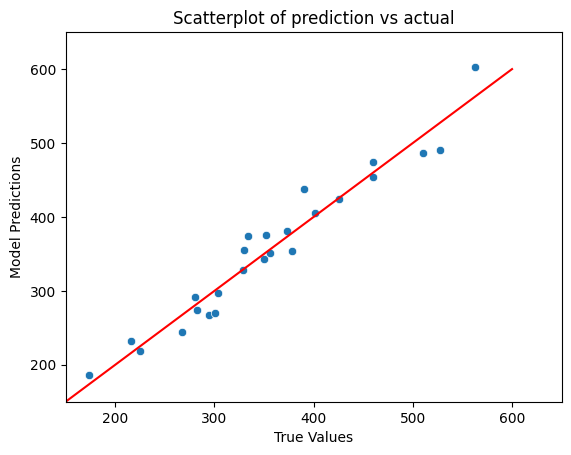

In [ ]:
sns.scatterplot(data = data,
               y = 'Model Predictions',
               x = 'True Values')

plt.xlim(150,650)
plt.ylim(150,650)
plt.plot([0,600],[0,600], color = 'red')
plt.title('Scatterplot of prediction vs actual')

plt.show()

In [ ]:
mean_squared_error(true_values, predictions_y)

498.1388012976609

# Coefficient analysis
-------------------------------------------------------------

In [ ]:
!pip install shap

In [ ]:
import shap

## SHAP results

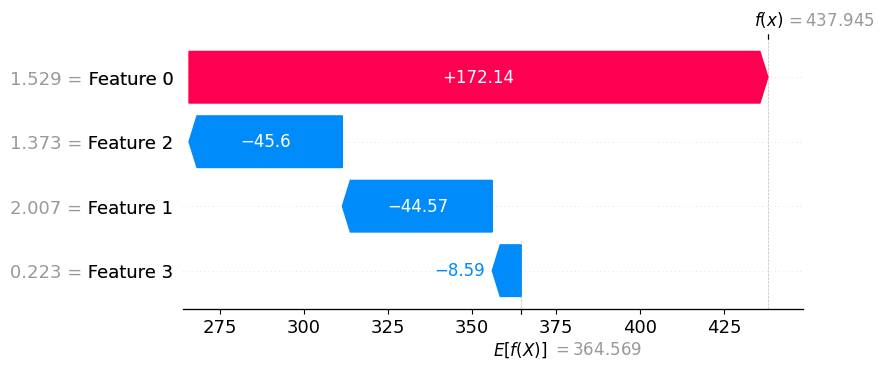

In [ ]:
#create an explainer for how values are calculated
explainer = shap.Explainer(lr.predict, X_train)
shap_values = explainer(X_train)\

exp = shap.Explanation(shap_values.values, shap_values.base_values[0][0], shap_values.data)
shap.plots.waterfall(exp[20])


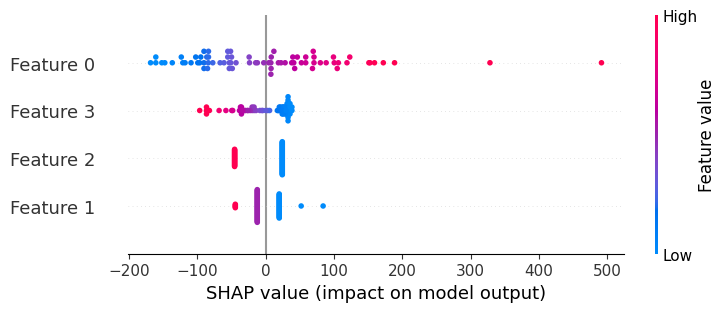

In [ ]:
shap.plots.beeswarm(exp)

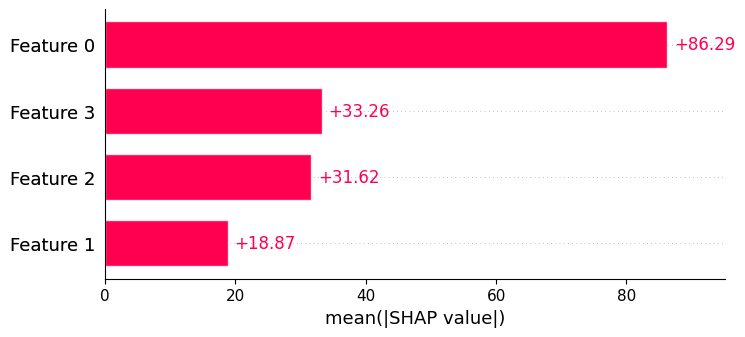

In [ ]:
shap.plots.bar(exp)

In [ ]:
X_train.columns # Feature names for the above graphs

Index(['size_sqft', 'num_bedrooms', 'num_floors', 'age_of_home'], dtype='object')

## SHAP Analysis



We can glean a few things from these results above regarding the feature coefficient values:
* The number of bedrooms, number of floors and age of the homes have negative coefficients. 
* Below, let's examine if the coefficients make sense. A negative coefficient means that a rise in the variable is inversely proportional to the response variable, price



We can also look at the SHAP values to understand feature importance in the Linear Regression:
* We see that Feature 0 ('size_sqft') is by far the most important feature in deciding our linear regressions
* This is followed by age of home and the number of floors which are less than half "as important"

## Feature visualizations

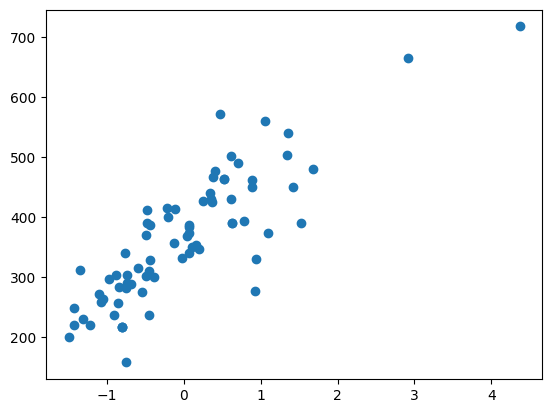

In [ ]:
plt.scatter(X_train['size_sqft'], y_train)

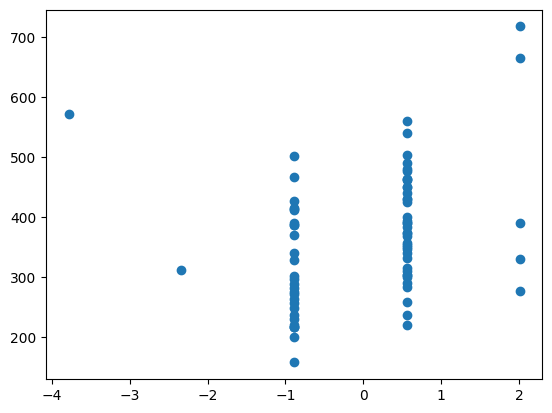

In [ ]:
plt.scatter(X_train['num_bedrooms'], y_train)

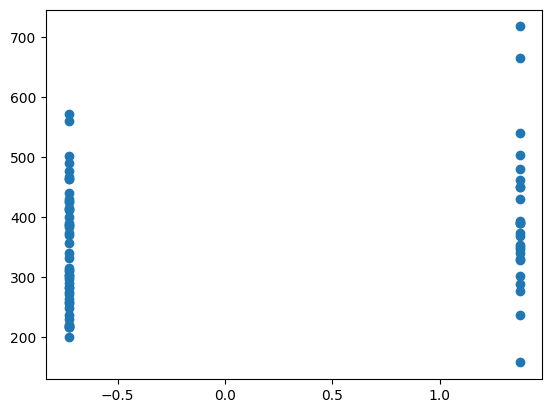

In [ ]:
plt.scatter(X_train['num_floors'], y_train)

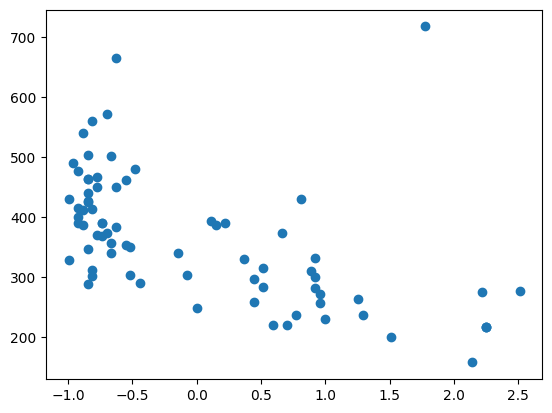

In [ ]:
plt.scatter(X_train['age_of_home'], y_train)

Here are the interpreted results from the graphs above:
* **Age_of_home** - seems to be somewhat negatively correlated, probably accurate but we can see there is a lot of variance
* **num_floors** - We can't really see a discernable difference. What we can tell is that the variance is larger when there are two floors. The average seems to be slightly lower, hence the negative correlation
* **num_bedrooms** - Seems to increase with number of bedrooms on the far end, but the overall relationship does not necessarily seem linear
* **size_sqft** - This is a more clearly positively correlated variable


# Regression on less features
-------------------------------------------------------------

Let's try the regression on just 1 feature, and then the 3 best features to see if we can improve our coeff. of determination

## 1 feature

In [ ]:
# Run regression with only best
scaler1 = StandardScaler()
lr1 = LinearRegression()

X_train_1 = pd.DataFrame(scaler1.fit_transform(np.array(X_train['size_sqft']).reshape(-1,1)), columns = ['size_sqft'])
X_test_1 =  pd.DataFrame(scaler1.transform(np.array(X_test[:, 0]).reshape(-1,1)), columns = ['size_sqft'])


lr1.fit(X_train_1, y_train)


print('coefficient of determination:', lr1.score(X_test_1, y_test))

predictions = lr1.predict(X_test_1)
predictions_y1 = [float(predictions[i]) for i in range(len(predictions))]

coefficient of determination: 0.7928676307403927


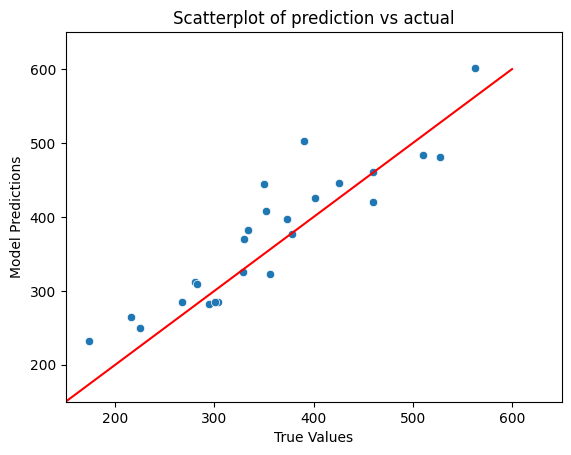

In [ ]:
true_values = [float(np.array(y_test)[i]) for i in range(len(predictions))]
data = pd.DataFrame({'Model Predictions': predictions_y1, 'True Values':true_values})
sns.scatterplot(data = data,
               y = 'Model Predictions',
               x = 'True Values')

plt.xlim(150,650)
plt.ylim(150,650)
plt.plot([0,600],[0,600], color = 'red')
plt.title('Scatterplot of prediction vs actual')

plt.show()

## 3 Features

In [ ]:
# Run regression with 3 best
scaler3 = StandardScaler()
lr3 = LinearRegression()

X_train_3 = pd.DataFrame(scaler3.fit_transform(np.array(X_train[['size_sqft', 'age_of_home', 'num_floors']])), columns = ['size_sqft', 'age_of_home', 'num_floors'])
X_test_3 =  pd.DataFrame(scaler3.transform(np.array(X_test[:, [0, 2, 3]])), columns = ['size_sqft', 'age_of_home', 'num_floors'])


lr3.fit(X_train_3, y_train)


print('coefficient of determination:', lr3.score(X_test_3, y_test))

predictions = lr3.predict(X_test_3)
predictions_y3 = [float(predictions[i]) for i in range(len(predictions))]

coefficient of determination: 0.8935977082278146


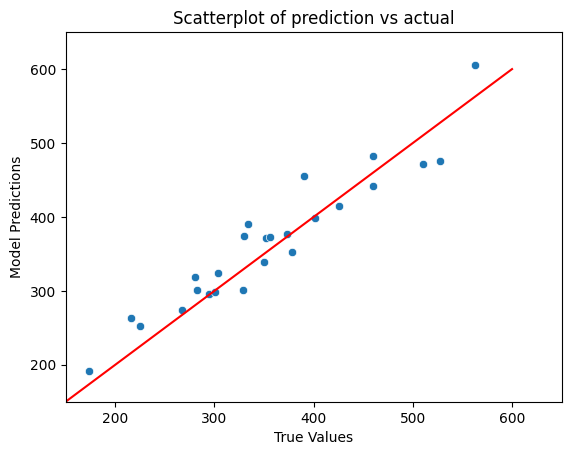

In [ ]:
true_values = [float(np.array(y_test)[i]) for i in range(len(predictions))]
data = pd.DataFrame({'Model Predictions': predictions_y3, 'True Values':true_values})
sns.scatterplot(data = data,
               y = 'Model Predictions',
               x = 'True Values')

plt.xlim(150,650)
plt.ylim(150,650)
plt.plot([0,600],[0,600], color = 'red')
plt.title('Scatterplot of prediction vs actual')

plt.show()

# MSE comparison of all models
-------------------------------------------------------------

In [ ]:
print('Respective MSE of 3 models on the testing data (all features, 1 feature, 3 features):', mean_squared_error(true_values, predictions_y), mean_squared_error(true_values, predictions_y1),mean_squared_error(true_values, predictions_y3))

Respective MSE of 3 models on the testing data (all features, 1 feature, 3 features): 498.1388012976609 1876.0997509254114 963.7378928519697


# Question 5. Predict the price of a house with a given set of features - 1200 sqft, 1 floor, 3 bedroom, 40 years old

Using our best model, with all features

In [ ]:
features = scaler.transform(np.array([1200, 3, 1, 40]).reshape(1, -1))

# Use linear regression model to predict the price of the house
predicted_price = lr.predict(features)
print(predicted_price[0])

[319.24633684]
